**Global Valrial**

In [2]:

root_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test"
path_pesi_old = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test/pesi/pesi.h5"
history_saving_path_json = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test/history.json"
save_checkpoints_path = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test/modellozzo_ckpt"

In [3]:

class_index = {'Adialer.C': 0,
                'Agent.FYI': 1,
                'Allaple.A': 2,
                'Allaple.L': 3,
                'Alueron.gen!J': 4,
                'Autorun.K': 5,
                'C2LOP.P': 6,
                'C2LOP.gen!g': 7,
                'Dialplatform.B': 8,
                'Dontovo.A': 9,
                'Fakerean': 10,
                'Instantaccess': 11,
                'Lolyda.AA1': 12,
                'Lolyda.AA2': 13,
                'Lolyda.AA3': 14,
                'Lolyda.AT': 15,
                'Malex.gen!J': 16,
                'Obfuscator.AD': 17,
                'Rbot!gen': 18,
                'Skintrim.N': 19,
                'Swizzor.gen!E': 20,
                'Swizzor.gen!I': 21,
                'VB.AT': 22,
                'Wintrim.BX': 23,
                'Yuner.A': 24}

**Setup Dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:

import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [6]:

path_root_give = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/Maling_dataset_Split/"
path_root = "/content/drive/MyDrive/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs/ClassMalware"

train_df_partial=pd.read_csv(os.path.join(path_root,"train_2.csv"))
test_df=pd.read_csv(os.path.join(path_root,"test_2.csv"))
val_df=pd.read_csv(os.path.join(path_root,"val_2.csv"))


train_df =pd.concat([train_df_partial, val_df], ignore_index = True)

In [7]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 32
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
        rescale=1 / 255.0)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=path_root,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 7481 validated image filenames belonging to 25 classes.
Found 1858 validated image filenames belonging to 25 classes.


In [8]:
classes = train_gen.class_indices

**Analysis of class distribution for each subset**

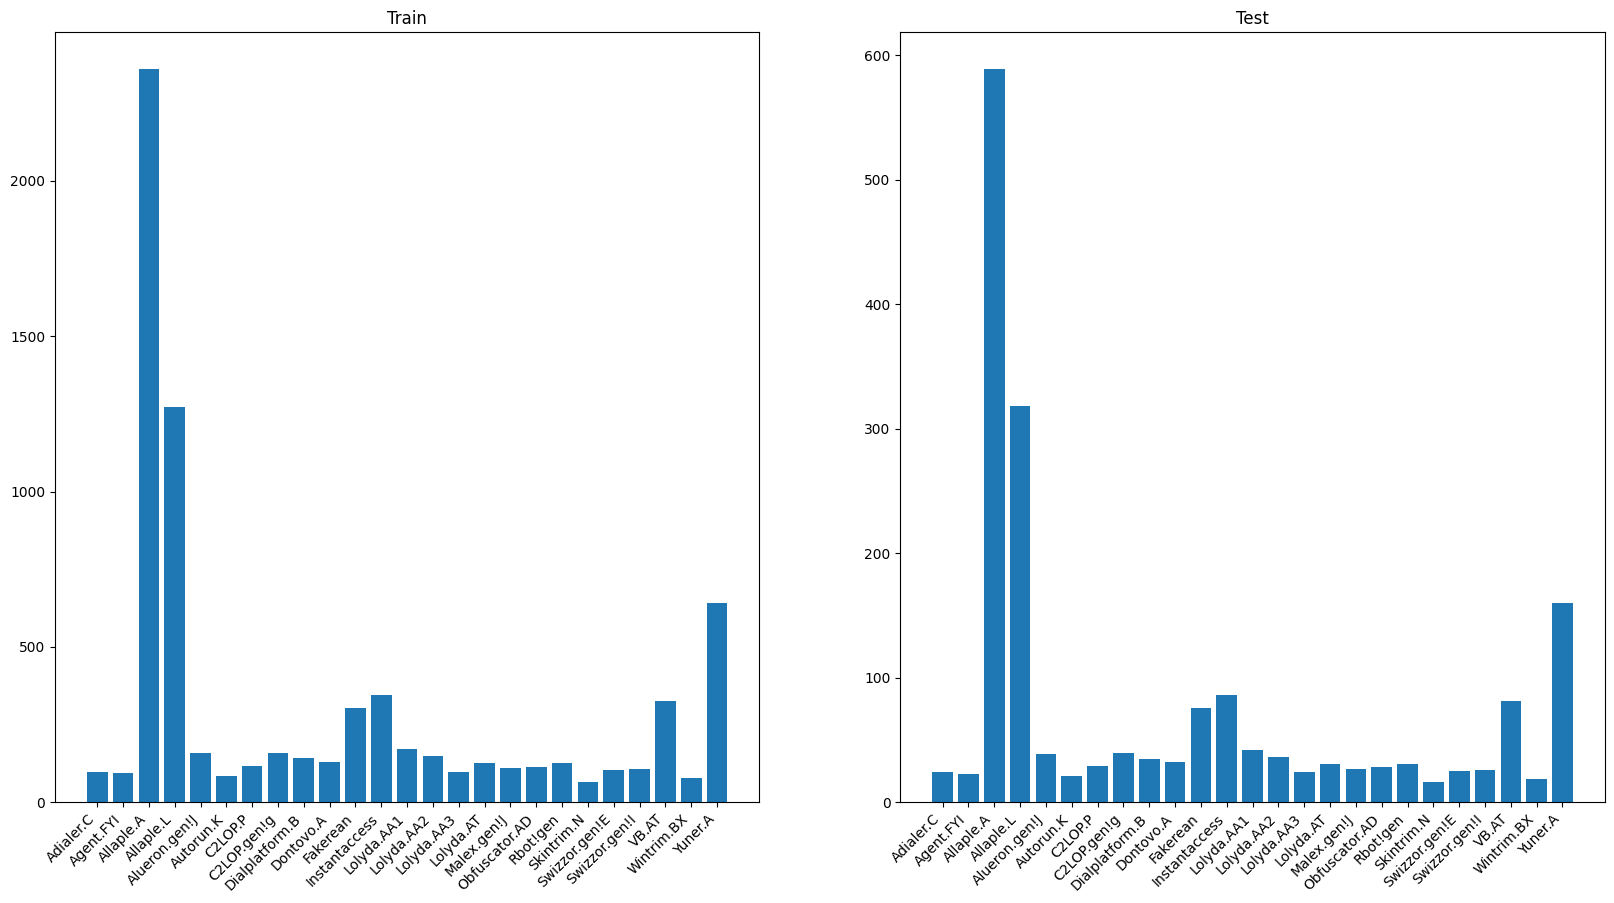

In [9]:
train_occ = train_df.groupby(by = "target").size()
test_occ = test_df.groupby(by = "target").size()
val_occ = val_df.groupby(by = "target").size()

occur = [train_occ, test_occ]
name = ["Train", "Test"]

plt.figure(figsize = (20,10))

for i in range(2):

  plt.subplot(1,2,i+1)
  plt.title(name[i])
  plt.xticks(rotation=45, ha="right")
  plt.bar(classes.keys(), occur[i])

plt.show()


# **Class weight calculation**

In [10]:

train_labels = train_df.replace({"target":class_index})['target'].to_numpy()
class_indices =np.array(list(class_index.values()))
class_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [11]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = class_indices,
                                                  y = train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 3.053469387755102,
 1: 3.2176344086021507,
 2: 0.12679661016949154,
 3: 0.23506677140612725,
 4: 1.8820125786163522,
 5: 3.5204705882352942,
 6: 2.5576068376068375,
 7: 1.87025,
 8: 2.1073239436619717,
 9: 2.301846153846154,
 10: 0.9811147540983607,
 11: 0.8673623188405797,
 12: 1.7499415204678364,
 13: 2.021891891891892,
 14: 3.0226262626262628,
 15: 2.3378125,
 16: 2.745321100917431,
 17: 2.6249122807017544,
 18: 2.356220472440945,
 19: 4.675625,
 20: 2.905242718446602,
 21: 2.8230188679245285,
 22: 0.9151070336391437,
 23: 3.8364102564102565,
 24: 0.4675625}

<BarContainer object of 25 artists>

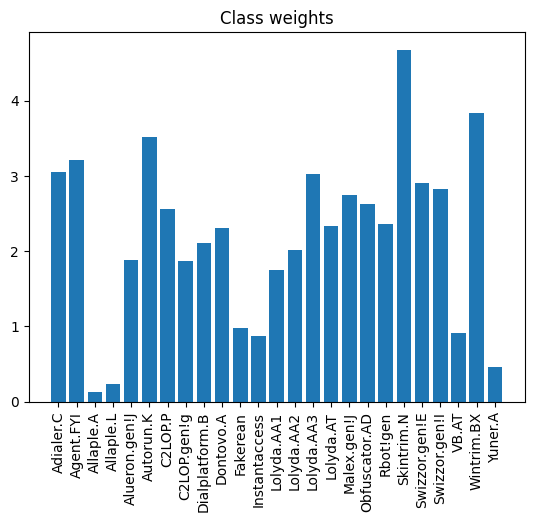

In [12]:
plt.title("Class weights")
plt.xticks(rotation = "vertical")
plt.bar(classes.keys(), class_weights.values())

# **Building the CNN**

In [13]:

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [14]:
num_classes = len(classes)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model


In [15]:
Malware_model = malware_model()
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 32)        0

In [16]:
cp_callback = ModelCheckpoint(save_checkpoints_path, verbose =1, monitor = "val_accuracy")

In [ ]:
#Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

# **Training**

In [17]:
history = Malware_model.fit(train_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
234/234 [==============================] - ETA: 0s - loss: 2.2861 - accuracy: 0.2482 - weighted_accuracy: 0.3272
Epoch 1: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test/modellozzo_ckpt
234/234 [==============================] - 1724s 7s/step - loss: 2.2861 - accuracy: 0.2482 - weighted_accuracy: 0.3272
Epoch 2/10
234/234 [==============================] - ETA: 0s - loss: 1.0449 - accuracy: 0.6900 - weighted_accuracy: 0.6829
Epoch 2: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test/modellozzo_ckpt
234/234 [==============================] - 1190s 5s/step - loss: 1.0449 - accuracy: 0.6900 - weighted_accuracy: 0.6829
Epoch 3/10
234/234 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.8257 - weighted_accuracy: 0.7823
Epoch 3: saving model to /content/drive/MyDrive/content/drive/MyDrive/progetto_SS/checkpoints_test_malimg_2_test/modellozzo_ckpt
234

# **History saving**

In [18]:

hist_df = pd.DataFrame(history.history)
with open(history_saving_path_json, 'wb') as file_pi:
    hist_df.to_json(file_pi)

# **Model training plots**

dict_keys(['loss', 'accuracy', 'weighted_accuracy'])


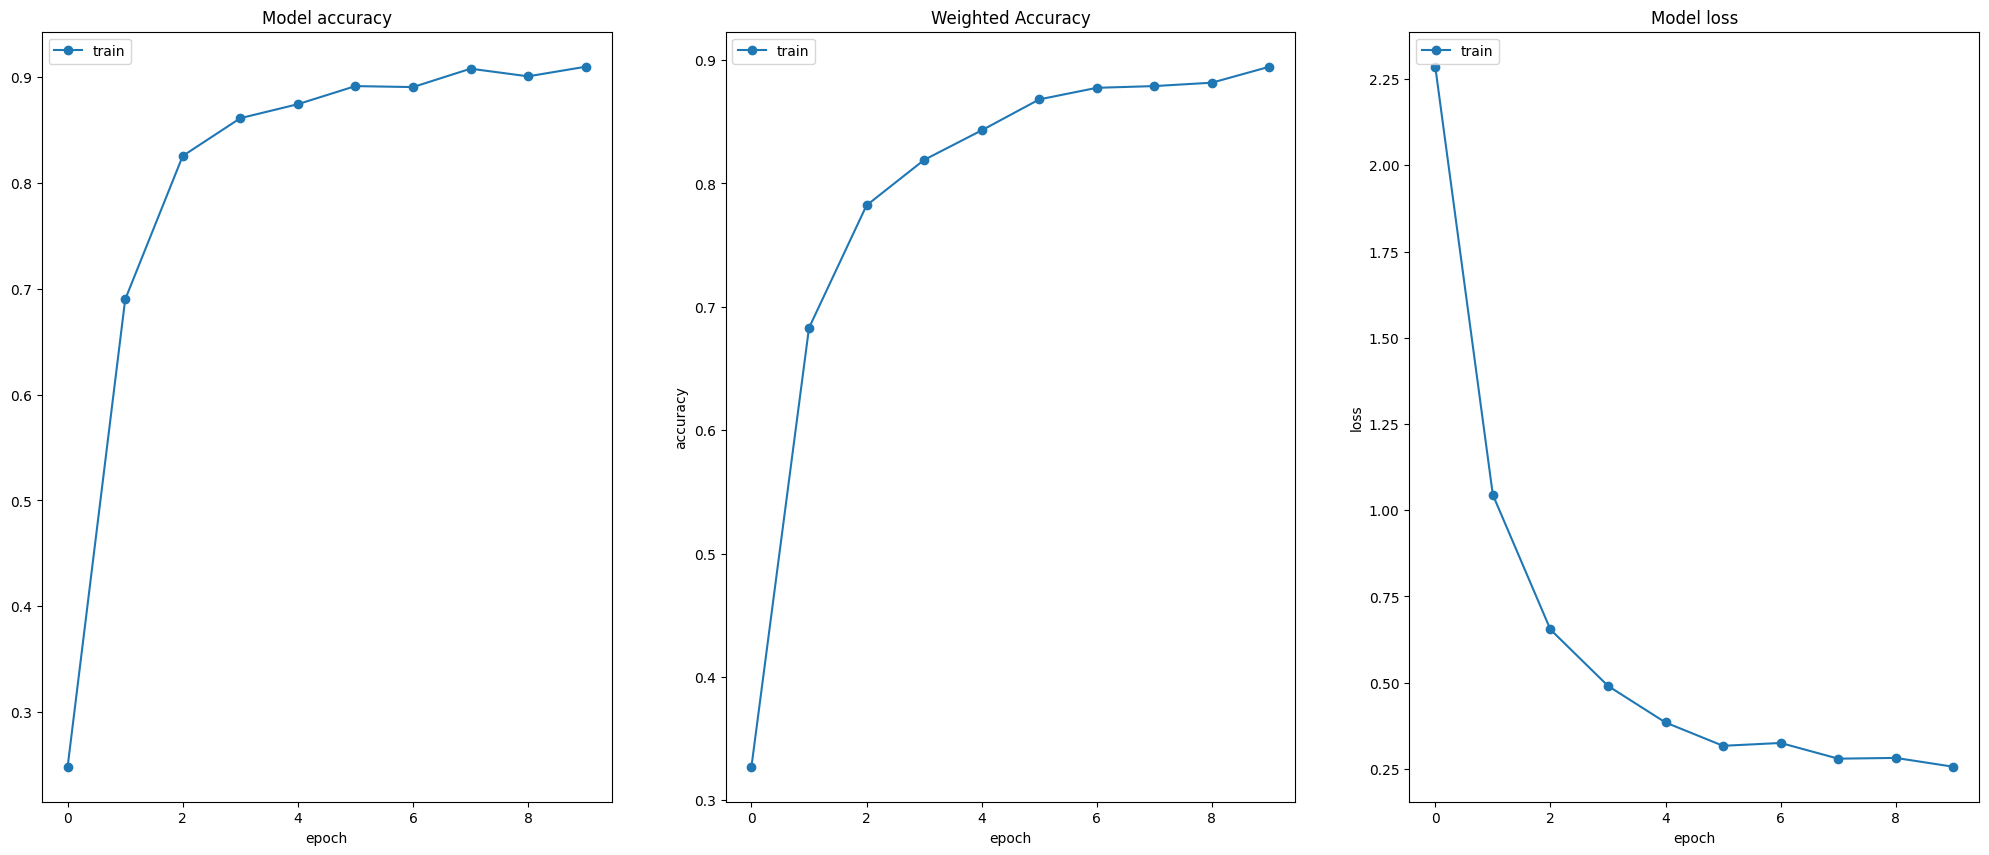

In [20]:
print(history.history.keys())
plt.figure(figsize = (25,10))
#  "Accuracy"
plt.subplot(1,3,1)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1,3,2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# "Loss"
plt.subplot(1,3,3)
plt.plot(history.history['loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# **Results on Test Set**


In [21]:
metric_list = Malware_model.evaluate(test_gen, batch_size=32, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])

59/59 [==============================] - 461s 8s/step - loss: 0.2169 - accuracy: 0.9483 - weighted_accuracy: 0.9483
evaluate_accuracy=0.948
evaluate_weighted_accuracy=0.948


# **Confusion matrix**

In [22]:
y_pred = Malware_model.predict(test_gen)
y_test_predicted = np.argmax(np.array(y_pred),axis = 1)

59/59 [==============================] - 99s 2s/step


In [23]:
from sklearn import metrics

In [24]:
c_matrix = metrics.confusion_matrix(test_gen.classes, y_test_predicted)
df_confusion = pd.crosstab(test_gen.classes, y_test_predicted)
df_confusion.to_csv(os.path.join(root_path,"confusion_matrix.csv"))

In [25]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

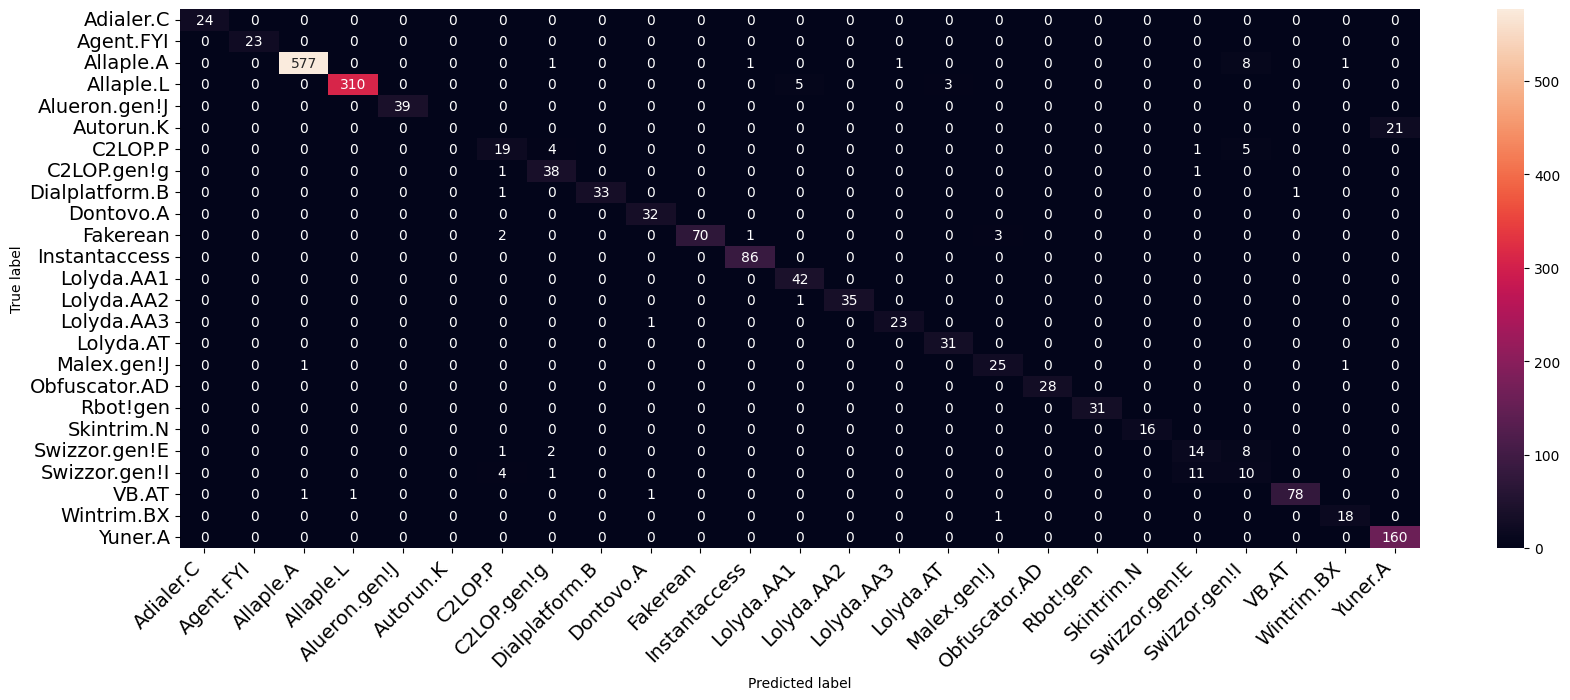

In [26]:
confusion_matrix(c_matrix, classes, figsize = (20,7), fontsize=14)

In [27]:
report = metrics.classification_report(test_gen.classes, y_test_predicted, target_names=classes,  output_dict=True)
print(report)

{'Adialer.C': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 24}, 'Agent.FYI': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 23}, 'Allaple.A': {'precision': 0.9965457685664939, 'recall': 0.9796264855687606, 'f1-score': 0.9880136986301369, 'support': 589}, 'Allaple.L': {'precision': 0.9967845659163987, 'recall': 0.9748427672955975, 'f1-score': 0.985691573926868, 'support': 318}, 'Alueron.gen!J': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 39}, 'Autorun.K': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 21}, 'C2LOP.P': {'precision': 0.6785714285714286, 'recall': 0.6551724137931034, 'f1-score': 0.6666666666666666, 'support': 29}, 'C2LOP.gen!g': {'precision': 0.8260869565217391, 'recall': 0.95, 'f1-score': 0.8837209302325583, 'support': 40}, 'Dialplatform.B': {'precision': 1.0, 'recall': 0.9428571428571428, 'f1-score': 0.9705882352941176, 'support': 35}, 'Dontovo.A': {'precision': 0.9411764705882353, 'recall': 1.0, 'f1-score':

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
df_report = pd.DataFrame(report).transpose()
df_report = df_report.round({'precision': 5, 'recall': 5, 'f1-score': 5})
df_report.to_csv(os.path.join(root_path,"report.csv"))